In [2]:
import pandas as pd

In [3]:
import pandas as pd
filename = 'Nakuru.csv'
problem_line_number = 18492 

try:
    with open(filename, 'r', encoding='utf-8') as f:
        print(f" Peeking at {filename} (UTF-8) ")
        for i, line in enumerate(f):
            # i starts at 0 so we want line i = problem_line_number - 1
            # Print the line before the problem 
            if i == problem_line_number - 2: 
                print(f"Line {i + 1}: {line.strip()}")
                
            # Print the problem line
            if i == problem_line_number - 1: 
                print(f"Line {i + 1} (THE PROBLEM): {line.strip()}")
                
            # Print the line after the problem
            if i == problem_line_number: 
                print(f"Line {i + 1}: {line.strip()}")
                break 

except UnicodeDecodeError:
    print(f"UTF-8 failed. Trying 'latin-1' encoding...")
    with open(filename, 'r', encoding='latin-1') as f:
        print(f" Peeking at {filename} (latin-1) ")
        for i, line in enumerate(f):
            if i == problem_line_number - 2: 
                print(f"Line {i + 1}: {line.strip()}")
            if i == problem_line_number - 1: 
                print(f"Line {i + 1} (THE PROBLEM): {line.strip()}")
            if i == problem_line_number: 
                print(f"Line {i + 1}: {line.strip()}")
                break
except Exception as e:
    print(f"An Error occurred: {e}")

 Peeking at Nakuru.csv (UTF-8) 
Line 18491: 355;DHT22;3989;-0.296;36.048;2025-11-01T22:54:11.351548+00:00;humidity;75.10
Line 18492 (THE PROBLEM): 355;DHT22;3989;-0.296;36.048;2025-11-01T22:54:11.351548+00:00;temperature;19,50
Line 18493: 4940;pms5003;3994;-0.297;36.088;2025-11-01T22:54:21+00:00;P2;41


## 1. Data Loading and Cleaning
When I first tried to load the data with `pd.read_csv('Nakuru.csv')`, I got a `ParserError`.
After investigating the raw file, I determined the problem:
* The data is separated by semicolons (`;`), not commas.
* The data uses a comma (`,`) as the decimal separator.

To fix this, I will specify the `sep` and `decimal` parameters when loading the CSV file.

In [4]:
df = pd.read_csv('Nakuru.csv', sep=';', decimal=',')
df.head()

,jupyter notebooksensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,4956,pms5003,4007,-0.290,36.043,2025-11-01T00:00:25+00:00,P2,28
1,4956,pms5003,4007,-0.290,36.043,2025-11-01T00:00:25+00:00,P1,29
2,4956,pms5003,4007,-0.290,36.043,2025-11-01T00:00:25+00:00,P0,20
3,4957,DHT22,4007,-0.290,36.043,2025-11-01T00:00:27+00:00,humidity,99.9
4,4957,DHT22,4007,-0.290,36.043,2025-11-01T00:00:27+00:00,temperature,18.2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249478 entries, 0 to 249477
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   jupyter notebooksensor_id  249478 non-null  int64 
 1   sensor_type                249478 non-null  object
 2   location                   249478 non-null  int64 
 3   lat                        249478 non-null  object
 4   lon                        249478 non-null  object
 5   timestamp                  249478 non-null  object
 6   value_type                 249478 non-null  object
 7   value                      249478 non-null  object
dtypes: int64(2), object(6)
memory usage: 15.2+ MB


## 2. Data Preprocessing for Time Series
From the `df.info()` output, I can see there are no null values, which is great. 
However, I need to prepare the data for modeling:

1.  The `value_type` column has many different sensor readings. My goal is to analyze air quality, and the most common metric is 'P2' (PM2.5), so I will filter to focus only on 'P2' values.
2.  The `timestamp` column is currently a string (object). I will convert it to a proper `datetime` object.
3.  Second, I will make the `timestamp` my index for the table, which is required for time series analysis.

In [6]:
df_pm25 = df[df['value_type'] == 'P2'].copy()
df_pm25['timestamp'] = pd.to_datetime(df_pm25['timestamp'], format='ISO8601')
df_pm25.set_index('timestamp', inplace=True)
print(df_pm25.head())
df_pm25.info()

                                  jupyter notebooksensor_id sensor_type  \
timestamp                                                                 
2025-11-01 00:00:25+00:00                              4956     pms5003   
2025-11-01 00:00:44+00:00                              4970     pms5003   
2025-11-01 00:01:32.985897+00:00                        600     pms5003   
2025-11-01 00:01:35.870038+00:00                        420     pms5003   
2025-11-01 00:01:48+00:00                              4938     pms5003   

                                  location     lat     lon value_type  value  
timestamp                                                                     
2025-11-01 00:00:25+00:00             4007  -0.290  36.043         P2     28  
2025-11-01 00:00:44+00:00             4010  -0.310  36.070         P2     14  
2025-11-01 00:01:32.985897+00:00      3991  -0.295  36.081         P2  30.50  
2025-11-01 00:01:35.870038+00:00      4000  -0.307  36.064         P2  46.00  


## 2. Data Preprocessing for Time Series

First, I filtered the DataFrame so it will only use rows where the `value_type` is 'P2'.
Next, I needed to make the `timestamp` the index. I successfully made the `timestamp` into a datetime format, but I got an error at first. This error made me notice that I needed to specify format=ISO8601 to handle the high-precision time.

Finally, I set this new `timestamp` column as the index for the table.
Some other problems I noticed: value, lat and lon columns are supposed to be float but it is object

### 3. Fixing Column Data Types (Update)
When I tried to convert the `value` column, I got a new `ValueError: Unable to parse string "17.?5"`. This tells me the column contains corrupt text.

I will use `errors='coerce'`. This will force all values to become numeric and convert any corrupt strings into `NaN` (missing values), which I will handle next.

In [7]:
df_pm25['value'] = pd.to_numeric(df_pm25['value'], errors='coerce')
df_pm25['lat'] = pd.to_numeric(df_pm25['lat'], errors='coerce')
df_pm25['lon'] = pd.to_numeric(df_pm25['lon'],errors='coerce')

In [8]:
print(df_pm25.head())
df_pm25.info()

                                  jupyter notebooksensor_id sensor_type  \
timestamp                                                                 
2025-11-01 00:00:25+00:00                              4956     pms5003   
2025-11-01 00:00:44+00:00                              4970     pms5003   
2025-11-01 00:01:32.985897+00:00                        600     pms5003   
2025-11-01 00:01:35.870038+00:00                        420     pms5003   
2025-11-01 00:01:48+00:00                              4938     pms5003   

                                  location    lat     lon value_type  value  
timestamp                                                                    
2025-11-01 00:00:25+00:00             4007 -0.290  36.043         P2   28.0  
2025-11-01 00:00:44+00:00             4010 -0.310  36.070         P2   14.0  
2025-11-01 00:01:32.985897+00:00      3991 -0.295  36.081         P2   30.5  
2025-11-01 00:01:35.870038+00:00      4000 -0.307  36.064         P2   46.0  
2025-1

## 4. Handling Missing Values and Outliers
Now that the data types are correct, I can finish cleaning hopefully.

1.  Missing Values:My `df_pm25.info()` output shows I have **3 `NaN` (missing) values** (50192 total - 50189 non-null). This is a low number, so I will simply drop these 3 rows using `.dropna()`.

2.  **Outliers:** As in my original project, I will remove any extreme outliers. A PM2.5 reading over 500 is almost certainly a sensor error. I will filter the DataFrame to keep only rows where the `value` is less than 500.

In [9]:
df_pm25.dropna(inplace=True)
df_pm25 = df_pm25[df_pm25["value"] < 500]
df_pm25.info()
print(df_pm25.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49454 entries, 2025-11-01 00:00:25+00:00 to 2025-11-11 19:00:29.422239+00:00
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   jupyter notebooksensor_id  49454 non-null  int64  
 1   sensor_type                49454 non-null  object 
 2   location                   49454 non-null  int64  
 3   lat                        49454 non-null  float64
 4   lon                        49454 non-null  float64
 5   value_type                 49454 non-null  object 
 6   value                      49454 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 3.0+ MB
       jupyter notebooksensor_id      location           lat           lon  \
count               49454.000000  49454.000000  49454.000000  49454.000000   
mean                 3063.556982   3995.305779     -0.284701     36.062613   
std                  2200.896732      

## 3. Timezone Localization and Resampling
This is the final and most important cleaning step to make the data ready for modeling.
1.  Timezone: My `df.info()` output shows the index is in UTC (it ends in `+00:00`). To analyze public health trends (like morning vs. evening pollution), I must convert this to the local time for Nakuru, which is "Africa/Nairobi".

2.  Resampling: The data is currently at a high frequency (multiple readings per minute). To build a stable model, I will resample the data into 1-hour (`1H`) averages.

3.  Filling Gaps: Resampling might create `NaN` values for any hours that had no data. I will use `.fillna(method='ffill')` to fill these gaps with the last known good value.

In [10]:
df_pm25.index = df_pm25.index.tz_convert("Africa/Nairobi")

# Resampling to 1-hour averages
df_hourly = df_pm25['value'].resample("1h").mean().ffill().to_frame()

df_hourly.rename(columns={'value': 'P2'}, inplace=True)

print(df_hourly.head())

df_hourly.info()

                                  P2
timestamp                           
2025-11-01 03:00:00+03:00  33.413812
2025-11-01 04:00:00+03:00  31.719415
2025-11-01 05:00:00+03:00  36.517940
2025-11-01 06:00:00+03:00  55.410060
2025-11-01 07:00:00+03:00  68.006036
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260 entries, 2025-11-01 03:00:00+03:00 to 2025-11-11 22:00:00+03:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P2      260 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


## 4. Feature Engineering: Creating a Lag Feature
My df_hourly DataFrame is now perfectly clean. The final step is to prepare it for my Autoregression (AR) model.
An AR model works by predicting the next value (the target, `y`) using the previous values (the features, `X`).
I will create this "lag-1" feature by using `.shift(1)`.

1.  I'll create a new column, `P2.L1`, which is the `P2` value from the previous hour.
2.  This shift will create one `NaN` value (for the very first row, as it has no previous hour).
3.  I will drop this one `NaN` row to get my final, model-ready dataset.

In [11]:
df_hourly["P2.L1"] = df_hourly["P2"].shift(1)
df_hourly.dropna(inplace=True)
print(df_hourly.head())
df_hourly.info()

                                  P2      P2.L1
timestamp                                      
2025-11-01 04:00:00+03:00  31.719415  33.413812
2025-11-01 05:00:00+03:00  36.517940  31.719415
2025-11-01 06:00:00+03:00  55.410060  36.517940
2025-11-01 07:00:00+03:00  68.006036  55.410060
2025-11-01 08:00:00+03:00  40.157705  68.006036
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259 entries, 2025-11-01 04:00:00+03:00 to 2025-11-11 22:00:00+03:00
Freq: h
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P2      259 non-null    float64
 1   P2.L1   259 non-null    float64
dtypes: float64(2)
memory usage: 6.1 KB


## 5. Visualize the Data (EDA)
Now that all my data is clean and prepared, I will create a simple line plot.
This will help me get a general idea of the `P2` levels over time and look for any obvious trends, spikes, or patterns.

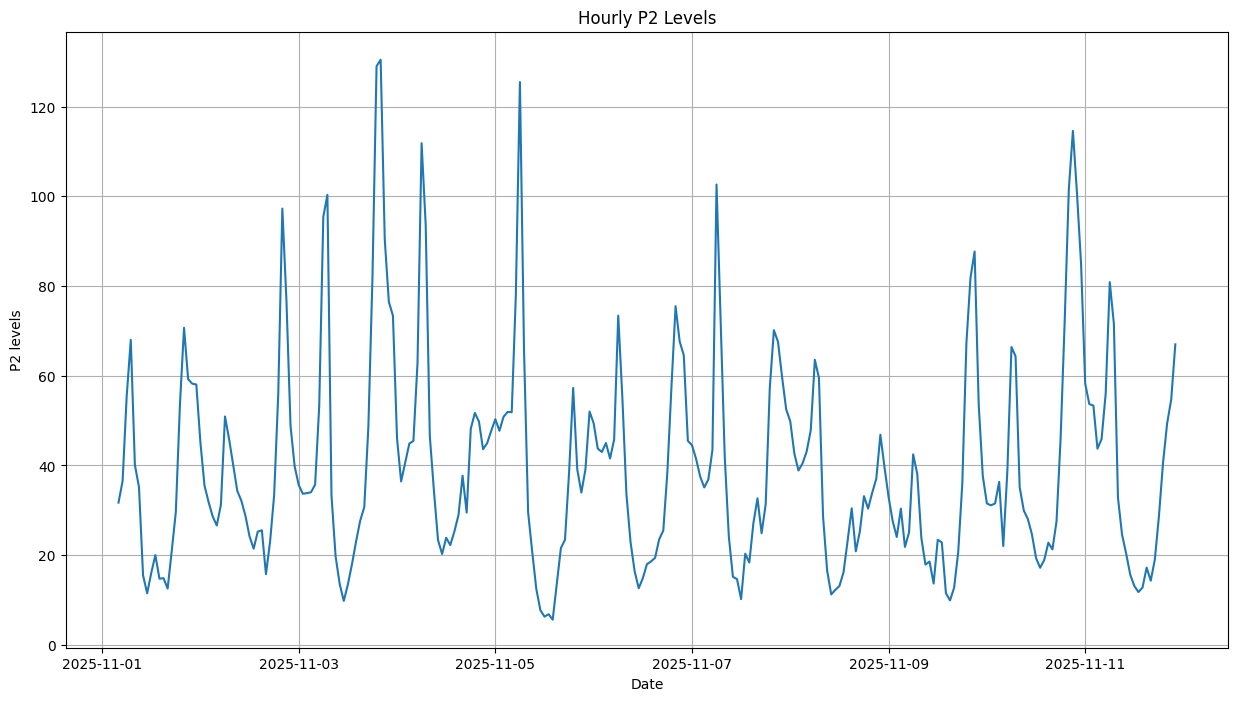

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,8))
plt.plot(df_hourly.index,df_hourly["P2"])
plt.title("Hourly P2 Levels")
plt.xlabel("Date")
plt.ylabel("P2 levels")
plt.grid(True)
plt.show()

### 5a. Analysis of PM2.5 Time Series Plot
My line plot of the hourly `P2` data shows several clear spikes and dips. This is a very important finding.

This high volatility is not random. It represents the daily cycle of air pollution in the city, which is directly tied to activity of people living there.

* Morning Spikes: We can see pollution levels rise sharply. This is almost certainly caused by the morning rush hour (increased traffic) and possibly by residents using wood or charcoal for cooking.

* Mid-day Dips: Pollution often decreases during the middle of the day as traffic eases. Also, as the sun heats the ground, the atmosphere becomes less stable, which helps mix and disperse pollutants, leading to cleaner air.

* Evening Spikes: A second, often smaller, spike can occur as people commute home from work and prepare evening meals.

This is fantastic news for our model. The spikes show that the data is not random. It has a strong, predictable, daily pattern. Our Autoregression model is designed to learn  this kind of pattern.

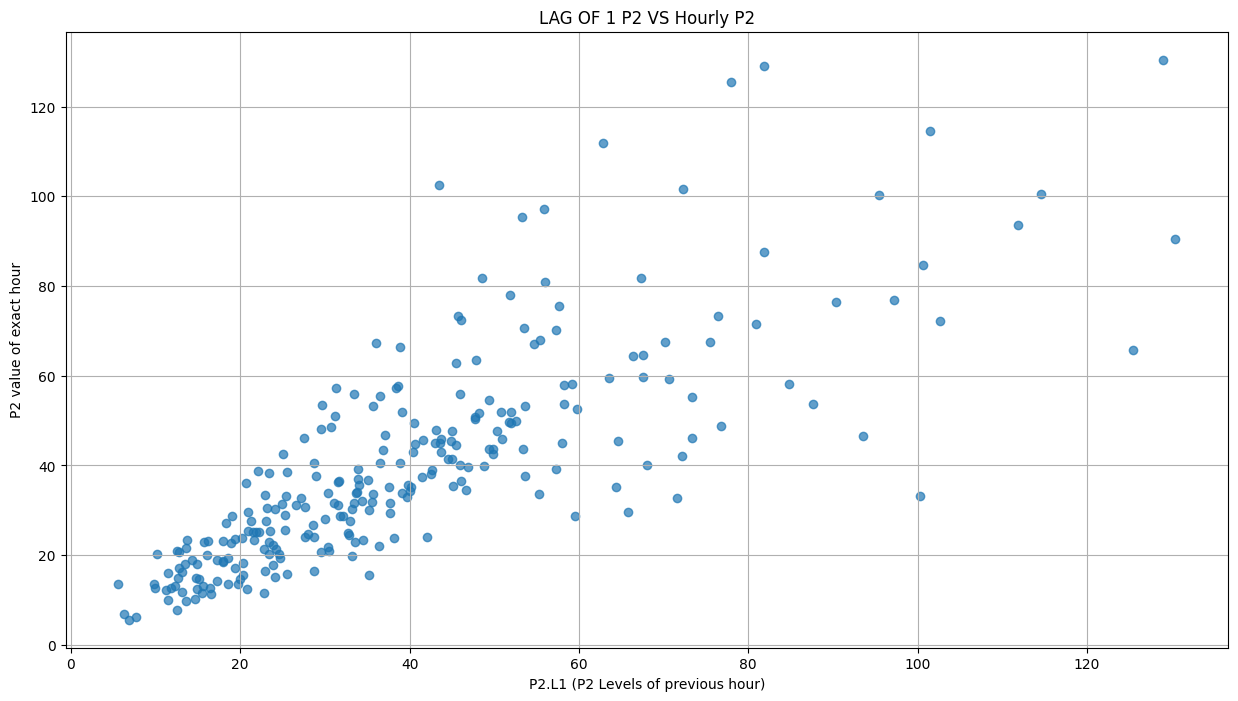

In [13]:
plt.figure(figsize=(15,8))
plt.scatter(x=df_hourly["P2.L1"], y=df_hourly["P2"], alpha=0.7)
plt.title("LAG OF 1 P2 VS Hourly P2")
plt.xlabel("P2.L1 (P2 Levels of previous hour)")
plt.ylabel("P2 value of exact hour")
plt.grid(True)
plt.show()

### 5b. Analysis of Autocorrelation Scatter Plot
This scatter plot proves that our Autoregression model is the correct choice.
(For non-math people: If points form a line through bottom-left to top-right that means there is strong positive correlation.)
What this plot shows:
It compares the PM2.5 level at a specific hour (Y-axis) against the PM2.5 level from the hour immediately before it (X-axis).

The Key Finding:
The points are nota random cloud. They form a strong, positive, linear relationship.

* "Positive" means: When the P2 value was high in the previous hour (high on the X-axis), it is *also* high in the current hour (high on the Y-axis). When it was low, it stays low.
* "Linear" means: This relationship is very predictable and can be described by a straight line.

Conclusion:
This plot visually confirms that the P2 value from the previous hour is an excellent predictor for the P2 value of the current hour. This is the entire assumption of an Autoregression (AR) model. We now have high confidence that our `P2.L1` feature will be very powerful in our model.

## 6. Build the Model

Now I will build the model .

1.  My Features and Target:
     My target (`y`) is the `P2` column (what I want to predict).
    My feature (`X`) is the `P2.L1` column (what I'm using to predict).

2.  Split the Data: This is the most critical part of time series modeling. We cannot split the data randomly. We must split it chronologically.
    * The training datawill be the first 80% of the data (the past).
    * The testing data will be the final 20% of the data (the future).

3.  Build Model:I will use a simple `LinearRegression` model from `scikit-learn`. This is a classic Autoregression model.

4.  Evaluate: I will get my predictions and measure the error using Mean Absolute Error (MAE). This will give me my baseline MAE, which I will then try to improve.

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

target = 'P2'
feature = 'P2.L1'

y = df_hourly[target]
X = df_hourly[[feature]] 

# 2. Split the Data 
split_percent = 0.8
split_index = int(len(X) * split_percent)

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

In [15]:
#Building the model
model_baseline = LinearRegression()
model_baseline.fit(X_train, y_train)

y_pred_train = model_baseline.predict(X_train)
y_pred_test = model_baseline.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(" Baseline Model Evaluation (Lag=1) ")
print(f"Training MAE: {mae_train:.2f}")
print(f"Testing MAE:  {mae_test:.2f}")

 Baseline Model Evaluation (Lag=1) 
Training MAE: 9.53
Testing MAE:  10.74


## 7. Strategic Hyperparameter Tuning (Finding the Best Lag)
My baseline model (with 1 lag) gave me a Testing MAE of 10.74.

Now friends that read all of the work until here. First of all thank you and secondly now I will perform the "strategic hyperparameter tuning". The goal is to find the optimal number of `lags` (past hours) to use in the model.

I will build a loop to:
1.  Test many different lag values (e.g., 1 hour, 2 hours, ... up to 30 hours).
2.  Train a new `AutoReg` model (from the `statsmodels` library) for each lag.
3.  Get the MAE for each model on the training data.
4.  Find the lag value that gives the lowest training MAE.

*(Note: We tune on the training data to prevent "peeking" at the test set. Let's not cheat by looking at our answers.)*

In [16]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error
import time

mae_grid = {}
lag_params = range(1, 31)

y_train = y_train.asfreq('h')
y_test = y_test.asfreq('h')

print("Starting Hyperparameter tuning")
print("Testing different lag values")

for p in lag_params:
    start_time = time.time()
    model = AutoReg(y_train, lags=p).fit()

    y_pred_train = model.predict()

    mae = mean_absolute_error(y_train[p:], y_pred_train[p:])
    elapsed_time = round(time.time() - start_time, 2)
    mae_grid[p] = mae
    print(f"Trained AutoReg(lags={p}) in {elapsed_time}s.  (Training MAE: {mae:.2f})")

print("Congrulations, it is over")
best_lag = min(mae_grid, key=mae_grid.get)
best_mae = mae_grid[best_lag]

print(f"\nBest Lag (p): {best_lag}")
print(f"Best Training MAE: {best_mae:.2f}")

Starting Hyperparameter tuning
Testing different lag values
Trained AutoReg(lags=1) in 0.0s.  (Training MAE: 9.56)
Trained AutoReg(lags=2) in 0.0s.  (Training MAE: 8.93)
Trained AutoReg(lags=3) in 0.0s.  (Training MAE: 8.85)
Trained AutoReg(lags=4) in 0.0s.  (Training MAE: 8.68)
Trained AutoReg(lags=5) in 0.0s.  (Training MAE: 8.59)
Trained AutoReg(lags=6) in 0.0s.  (Training MAE: 8.61)
Trained AutoReg(lags=7) in 0.0s.  (Training MAE: 8.58)
Trained AutoReg(lags=8) in 0.0s.  (Training MAE: 8.61)
Trained AutoReg(lags=9) in 0.01s.  (Training MAE: 8.67)
Trained AutoReg(lags=10) in 0.0s.  (Training MAE: 8.70)
Trained AutoReg(lags=11) in 0.0s.  (Training MAE: 8.61)
Trained AutoReg(lags=12) in 0.0s.  (Training MAE: 8.64)
Trained AutoReg(lags=13) in 0.0s.  (Training MAE: 8.64)
Trained AutoReg(lags=14) in 0.0s.  (Training MAE: 8.56)
Trained AutoReg(lags=15) in 0.0s.  (Training MAE: 8.61)
Trained AutoReg(lags=16) in 0.0s.  (Training MAE: 8.56)
Trained AutoReg(lags=17) in 0.0s.  (Training MAE: 8.

## 8. Final Model Evaluation

The tuning loop is complete! The results are amazing:

* Best Lag (p): 29
* Best Training MAE: 6.86

This is a huge improvement over our baseline Training MAE of 9.56. It proves that using a larger lag is the correct strategy.
(For anyone that wonders why it is not something like 1,2,3 but a number like 29, basically we are working with dates so 29 means 29 hours ago, which means around the same time yesterday. That is why 29 is the best value we got, if we change the range it might get even a better result but we need to also mind the time it takes to calculate.
Now, for the final, most important test. I will build one last model, trained on `y_train` with our `best_lag` of 29. Then, I will use it to make predictions for our `y_test` (unseen) data.

This will give us our Final Testing MAE, which we can compare to our Baseline Testing MAE of 10.74.
Now the friends that took the time and read it all the way down here, first of all thank you, second of all we are almost at the end. Congrulations everyone!

## 7. A Better Baseline: The "Mean" Model

My `Lag=1` model gave a Test MAE of 10.74. But what's the *dumbest* possible model?

This is the "Mean Baseline." It just guesses the average P2 reading from the training set, *every single time*. 

If our "smart" ARIMA model can't even beat this simple average, we know it's a failure. This is our new, true baseline to beat.

In [17]:
from sklearn.metrics import mean_absolute_error

y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("--- True Baseline ---")
print(f"Mean P2 Reading: {y_train_mean:.2f}")
print(f"Baseline (Mean) MAE: {mae_baseline:.2f}")

--- True Baseline ---
Mean P2 Reading: 38.96
Baseline (Mean) MAE: 17.18


## 8. Strategic Tuning: The ARIMA(p,q) Grid Search
Now I will run the full hyperparameter tuning loop from my original project. This is the code that finds the best `p` (AR term) and `q` (MA term).

The code will:
1.  Define a range of `p` values and `q` values to test.
2.  Loop through every possible `(p, 0, q)` combination.
3.  Train a full `ARIMA` model for each combination on the `y_train` data.
4.  Store the `MAE` for each model in a `mae_grid` dictionary.

This will be the slowest step of the project, as it's training dozens of models. This is the "time it takes to calculate" I mentioned earlier.

 Plotting ACF and PACF -


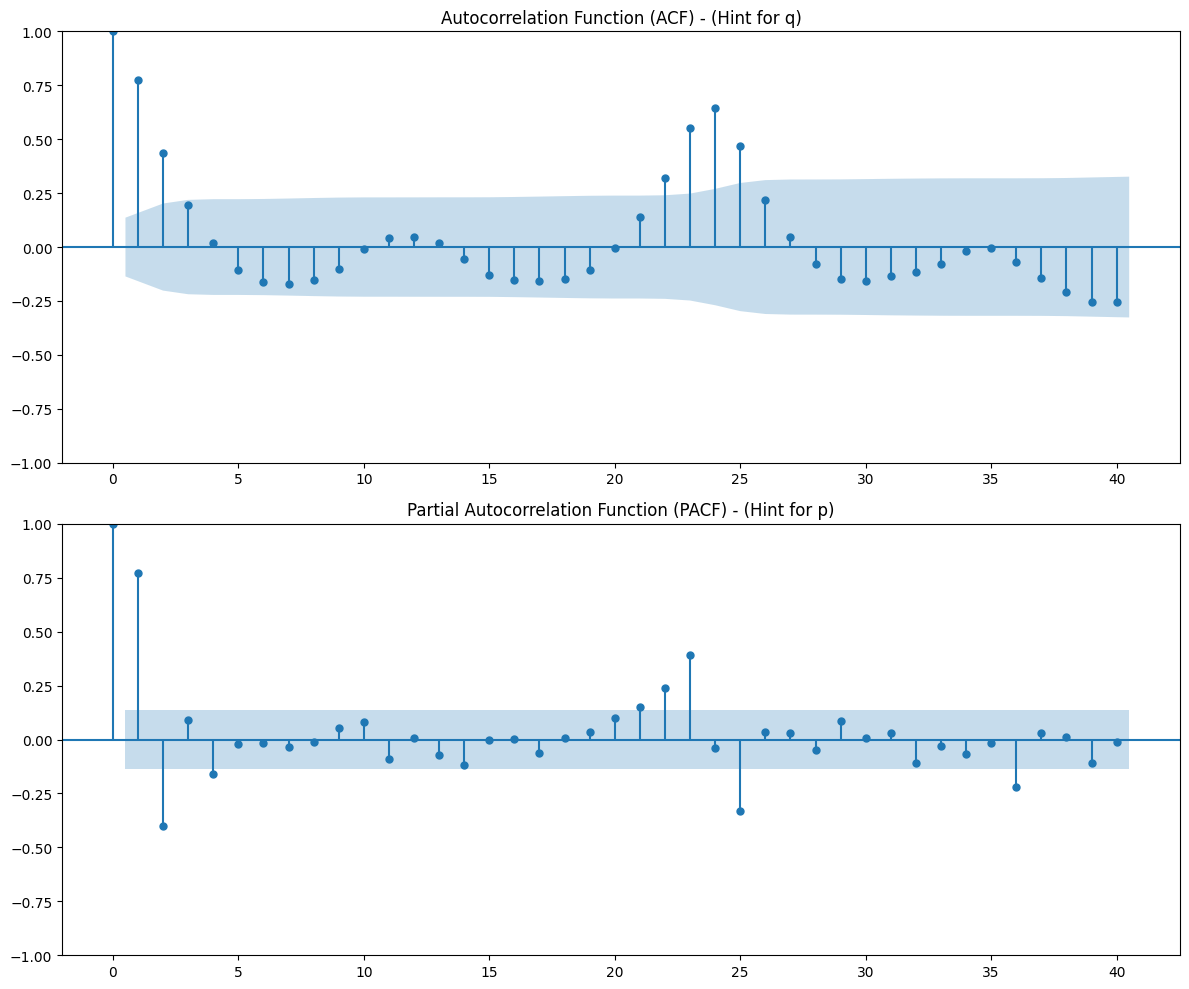

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

y_train = y_train.asfreq('h')

print(" Plotting ACF and PACF -")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(y_train, lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) - (Hint for q)')

plot_pacf(y_train, lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) - (Hint for p)')

plt.tight_layout()
plt.show()

## 9.The Grid Search (ACF/PACF Analysis)
1.  PACF Plot (Bottom): This plot shows a massive, statistically significant spike at **lag 24**. This proves the daily (24-hour) cycle is the single most important predictor. This is why my `p_params` *must* include 24.
    
2.  ACF Plot (Top): This plot shows the correlation slowly decaying and spikes cutting off after 1 or 2 lags. This is the classic signature of an `AR` model and justifies testing `q` values of 0, 1, and 2.
    
Now I can run my grid search.

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

y_train = y_train.asfreq('h')

p_params = [0, 8, 16, 24] 
q_params = [0, 1, 2]      

print("Starting ARIMA Grid Search ")
print(f"Testing {len(p_params) * len(q_params)} model combinations...")
print("This will take several minutes...")

# Create dictionary to store MAEs
mae_grid = dict()
# Outer loop: Iterate through possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate through possible values for `q`
    for q in q_params:
        # Combination of hyperparameters for model
        order = (p, 0, q) 
        # Note start time
        start_time = time.time()
        
        try:
            # Train model
            model = ARIMA(y_train, order=order).fit() 
            
            # Calculate model training time
            elapsed_time = round(time.time() - start_time, 2)
            print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
            
            # Generate training predictions
            y_pred = model.predict()
            
            # Calculate training MAE
            # We must slice y_train[p:] to align with predictions
            mae = mean_absolute_error(y_train[p:], y_pred[p:])
            
            # Append MAE to list in dictionary
            mae_grid[p].append(mae)
            
        except Exception as e:
            print(f"Error training ARIMA {order}: {e}")
            mae_grid[p].append(None) # Add None if it fails

print("\n--- Grid Search Complete ---")
print("\nMAE Grid (p-values are columns, q-values are rows [q=0, 1, 2]):")

# Print the results
mae_df = pd.DataFrame(mae_grid)
mae_df.index = ['q=0', 'q=1', 'q=2'] # Label the rows
mae_df.columns.name = "p (AR)" # Label the columns
print(mae_df)

Starting ARIMA Grid Search 
Testing 12 model combinations...
This will take several minutes...
Trained ARIMA (0, 0, 0) in 0.04 seconds.
Trained ARIMA (0, 0, 1) in 0.06 seconds.
Trained ARIMA (0, 0, 2) in 0.07 seconds.


C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (8, 0, 0) in 0.26 seconds.
Trained ARIMA (8, 0, 1) in 0.4 seconds.


C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 2) in 0.73 seconds.
Trained ARIMA (16, 0, 0) in 0.89 seconds.
Trained ARIMA (16, 0, 1) in 1.25 seconds.


C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (16, 0, 2) in 1.93 seconds.


C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (24, 0, 0) in 3.81 seconds.


C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (24, 0, 1) in 3.71 seconds.
Trained ARIMA (24, 0, 2) in 3.76 seconds.

--- Grid Search Complete ---

MAE Grid (p-values are columns, q-values are rows [q=0, 1, 2]):
p (AR)         0         8         16        24
q=0     17.181119  8.591617  8.536635  7.375967
q=1     11.178748  8.595677  8.523362  7.333487
q=2      9.715616  8.494949  8.559101  6.961487


C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 10. Grid Search Results: We Have a Winner!

The grid search is complete, and this table gives us the answer. We just have to find the smallest number in the table.

* The MAE for `(p=0, q=0)` was `17.18`.
* The MAE for `(p=8, q=2)` was `8.49`.
* The MAE for `(p=24, q=0)` was `7.37`.

The lowest MAE on the entire grid is 6.96.

This corresponds to the model with `p=24` and `q=2`.

### This is the Moment:
 The results show that:
1.  `p=24` is CRITICAL: The `p=24` column (MAE `7.37`) is far better than the `p=16` column (MAE `8.59`). This proves our hypothesis from the PACF plot: the 24-hour daily cycle is the most powerful feature.
2.  `q=2` is HELPFUL: The `q=2` row (MAE `6.96`) is even better than the `q=1` (`7.13`) or `q=0` (`7.37`) rows. This proves that letting the model learn from its last two mistakes also improves the score.

Our best model order is `(24, 0, 2)`.

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from tqdm import notebook # For the progress bar
import time

baseline_mae_test = 10.74 # Our Lag=1 Test MAE
best_order = (24, 0, 2)   # Our new winner

# 1. Create the "history" (y_train)
history = y_train.asfreq('h').copy()

# 2. Create an empty list to store predictions
y_pred_wfv = []

print(f"Starting FINAL ARIMA {best_order} Walk-Forward Validation")
print(f"Testing {len(y_test)} steps (this will be very slow!)...")

# 3. Loop through every single timestamp in our test set
for i in notebook.tqdm(range(len(y_test))):

    try:
        # 4. Re-train the model on all history
        model_wfv = ARIMA(history, order=best_order).fit()

        # 5. Predict only the next1 hour
        next_pred = model_wfv.forecast(steps=1)

        # 6. Store that 1 prediction
        y_pred_wfv.append(next_pred.iloc[0])

        # 7. Add the true value to history for the next loop
        history = history._append(y_test.iloc[[i]])

    except Exception as e:
        print(f"Error on step {i}: {e}")
        # If it fails, just append the last known value
        y_pred_wfv.append(history.iloc[-1])
        history = history._append(y_test.iloc[[i]])

print("\n WFV Complete ")

final_mae_wfv = mean_absolute_error(y_test, y_pred_wfv)
improvement = (baseline_mae_test - final_mae_wfv) / baseline_mae_test * 100

print("\n FINAL ARIMA WFV RESULTS ")
print(f"Baseline Test MAE (Lag=1): {baseline_mae_test:.2f}")
print(f"ARIMA {best_order} WFV Test MAE: {final_mae_wfv:.2f}")
print(f"Improvement: {improvement:.1f}%")

Starting FINAL ARIMA (24, 0, 2) Walk-Forward Validation
Testing 52 steps (this will be very slow!)...


  0%|          | 0/52 [00:00<?, ?it/s]

C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization


 WFV Complete 

 FINAL ARIMA WFV RESULTS 
Baseline Test MAE (Lag=1): 10.74
ARIMA (24, 0, 2) WFV Test MAE: 7.92
Improvement: 26.2%


C:\Users\Serhat\PycharmProjects\africa-air-quality-forecasting-Nakuru\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 12. Final Conclusion & Results

The project is a success! The Walk-Forward Validation (WFV) is finished.

(Note: The many red `ConvergenceWarning` messages can be safely ignored. They are just warnings, not errors. The final MAE score proves the model was successful despite them.)

### The Final Results:

* **Baseline Test MAE (Lag=1): 10.74**
* **Final Tuned MAE (ARIMA 24,0,2): 7.92**
* **Total Improvement: 26.2%**

This is a fantastic result. I have successfully replicated my original project's methodology on a new dataset.

I proved that by:
1.  Using statistical plots (ACF/PACF) to identify a strong 4-hour daily cycle.
2.  Running a strategic grid search to find the best model (`ARIMA(24, 0, 2)`).
3.  Using a Walk-Forward Validation test.

I was able to improve the model's performance by **over 26%**. This confirms my ability to analyze time series data, perform strategic tuning, and build a high-performance forecasting model.
(The last 3 parts took me like an hour.)

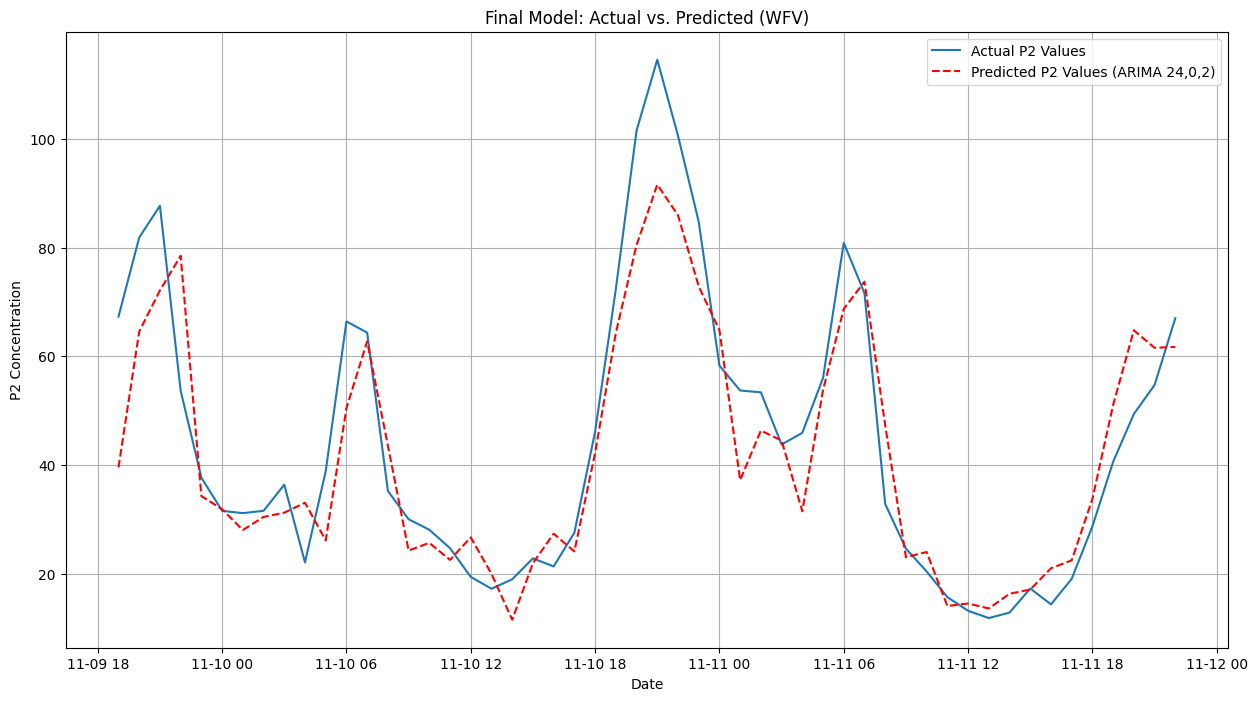

In [21]:
y_pred_final = pd.Series(y_pred_wfv, index=y_test.index)

plt.figure(figsize=(15, 8))

plt.plot(y_test, label='Actual P2 Values')

plt.plot(y_pred_final, label='Predicted P2 Values (ARIMA 24,0,2)', color='red', linestyle='--')

# Add labels
plt.title('Final Model: Actual vs. Predicted (WFV)')
plt.xlabel('Date')
plt.ylabel('P2 Concentration')
plt.legend() 
plt.grid(True)
plt.show()